# Benchmarking RNA-seq DEG Methods with the Dexamethasone Benchmarking Resource

This notebook reads in designated meta data and RNA-seq expression data files from a dexamethasone study and performs two DEG methods, characteristic direction and log fold change, on the data using code adapted from Bulk RNA-seq Analysis pipeline appyter: https://appyters.maayanlab.cloud/Bulk_RNA_seq/

The results of the DEG methods are benchmarked after enrichment analysis focused on the NR3C1 transcription factor, the known target of dexamethasone.

In [143]:
# Import libraries
import os
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import requests
import scipy.stats as ss
from maayanlab_bioinformatics.normalization.filter import filter_by_expr
from maayanlab_bioinformatics.dge.characteristic_direction import characteristic_direction
from maayanlab_bioinformatics.dge.limma_voom import limma_voom_differential_expression
from maayanlab_bioinformatics.enrichment import enrich_crisp
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from math import log2, ceil
from IPython.display import display, Markdown
from random import sample
from maayanlab_bioinformatics.plotting.bridge import bridge_plot
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import seaborn as sns


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load in Data

Using data from GEO from the study ["Development of a glucocorticoid exposure signature for SLE" (GSE159094)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE159094)

In [12]:
# Set all variables
meta_class_column_name = 'Class'
control_name = 'Control'
treatment_name = 'Dex'

data_dir = '../RNAseq_data'
gse = 'GSE159094'
meta_data_filename = f'{gse}_series_matrix.txt'
rnaseq_data_filename = f'{gse}_counts.txt'

In [13]:
# Load in metadata
try:
    if meta_data_filename.endswith('.csv'): 
        meta_df = pd.read_csv(f"{data_dir}/{meta_data_filename}", index_col=0)
    else:
        meta_df = pd.read_csv(f"{data_dir}/{meta_data_filename}", sep="\t", index_col=0)
    print(f"Metadata file shape: {meta_df.shape[0]} samples, {meta_df.shape[1]} features")
except:
    print("Error! Please ensure the metadata file is in CSV, TXT, or TSV format.")

# Load in data
try:
    if rnaseq_data_filename.endswith('.csv'): 
        expr_df = pd.read_csv(f"{data_dir}/{rnaseq_data_filename}", index_col=0).sort_index()
    else:
        expr_df = pd.read_csv(f"{data_dir}/{rnaseq_data_filename}", sep="\t", index_col=0).sort_index()
    print(f"RNA-seq data file shape: {expr_df.shape[0]} genes, {expr_df.shape[1]} samples")
except:
    print("Error! Please ensure the RNA-seq file is in CSV, TXT, or TSV format.")

# Match samples between the metadata and the dataset
if meta_class_column_name not in meta_df.columns:
    print(f"Error! Column '{meta_class_column_name}' was not found in the metadata.")

shared_samples = set(meta_df.index).intersection(expr_df.columns)
meta_df = meta_df[meta_df.index.isin(shared_samples)]
meta_df = pd.concat([
    meta_df[meta_df['Class'] == control_name],
    meta_df[meta_df['Class'] == treatment_name]
]) 
expr_df = expr_df[meta_df.index]
print(f"\nThe pipeline will be run on {len(shared_samples)} samples.")

Metadata file shape: 8 samples, 3 features
RNA-seq data file shape: 27780 genes, 8 samples

The pipeline will be run on 8 samples.


In [5]:
## Filter out non-expressed genes
expr_df = expr_df.loc[expr_df.sum(axis=1) > 0, :]
## Filter out lowly expressed genes
expr_df = filter_by_expr(expr_df, group=meta_df[meta_class_column_name].apply(lambda x: x==treatment_name))
print(f"Number of genes after filtering by low expression: {expr_df.shape[0]}")

Number of genes after filtering by low expression: 15376


In [6]:
# Display meta data
meta_df

,Class,Pair,SRA
Sample_geo_accession,,,
GSM4819298,Control,A,SRR12780596
GSM4819299,Control,B,SRR12780597
GSM4819300,Control,C,SRR12780598
GSM4819301,Control,D,SRR12780599
GSM4819286,Dex,A,SRR12780584
GSM4819287,Dex,B,SRR12780585
GSM4819288,Dex,C,SRR12780586
GSM4819289,Dex,D,SRR12780587


In [7]:
# Display expression data
expr_df

,GSM4819298,GSM4819299,GSM4819300,GSM4819301,GSM4819286,GSM4819287,GSM4819288,GSM4819289
Gene,,,,,,,,
A1BG,47,34,81,68,47,43,64,108
A1BG-AS1,100,39,131,138,115,64,128,136
A2M,86,152,67,63,142,183,52,76
A2M-AS1,11,7,6,2,9,13,15,10
A4GALT,58,46,23,126,96,47,26,146
...,...,...,...,...,...,...,...,...
ZXDC,1172,1433,1091,1161,1241,1320,1219,1617
ZYG11B,586,400,584,558,568,609,609,816
ZYX,8578,16603,5281,7752,8013,12881,4818,8480


# Differential Gene Expression Methods

In [8]:
signatures = {}

### Characteristic Direction

In [17]:
# Function for computing signatures with characteristic direction
def cd_signature(control, treatment, data, metadata, meta_class_column_name):
    
    ctrl_ids = metadata.loc[metadata[meta_class_column_name]==control, :].index.tolist() #control
    case_ids = metadata.loc[metadata[meta_class_column_name]==treatment,:].index.tolist() #case
    
    signature = characteristic_direction(
        data.loc[:, ctrl_ids], 
        data.loc[:, case_ids], 
        calculate_sig=True
    )
    signature = signature.sort_values("CD-coefficient", ascending=False)
    signature['Significance'] = signature['CD-coefficient'].apply(abs)
    
    return signature

if not os.path.exists(f'../RNAseq_data/signatures/{gse}/cd.tsv'): 
    signatures['cd'] = cd_signature(control_name, treatment_name, expr_df, meta_df, meta_class_column_name)
    signatures['cd'].to_csv(f'../RNAseq_data/signatures/{gse}/cd.tsv', sep='\t')
else:
    signatures['cd'] = pd.read_csv(f'../RNAseq_data/signatures/{gse}/cd.tsv', sep='\t', index_col=0)
display(Markdown(f"Characteristic Direction Signature"))
display(signatures['cd'][['CD-coefficient']])

Characteristic Direction Signature

,CD-coefficient
Gene,
TXNIP,0.598894
THBS1,0.388535
ETS1,0.184504
TSC22D3,0.169194
FKBP5,0.150122
...,...
TGFBI,-0.088838
FTH1,-0.090782
B2M,-0.112363


## Limma-Voom

In [21]:
# Function for computing signatures
def limma(control, treatment, data, metadata, meta_class_column_name):

    ctrl_ids = metadata.loc[metadata[meta_class_column_name] == control, :].index.tolist()  # control
    case_ids = metadata.loc[metadata[meta_class_column_name] == treatment, :].index.tolist()  # case

    # run limma
    signature = limma_voom_differential_expression(
        data.loc[:, ctrl_ids],
        data.loc[:, case_ids],
        voom_design=True,
        filter_genes=False
    )
    signature = signature.sort_values("t", ascending=False)
    signature['Significance'] = signature['P.Value']
    signature['StatVal'] = signature['t'].apply(abs)

    # return result
    return signature

if not os.path.exists(f'../RNAseq_data/signatures/{gse}/limma-voom.tsv'): 
    signatures['limma'] = limma(control_name, treatment_name, expr_df, meta_df, meta_class_column_name)
    signatures['limma'].to_csv(f'../RNAseq_data/signatures/{gse}/limma.tsv', sep='\t')
else:
    signatures['limma'] = pd.read_csv(f'../RNAseq_data/signatures/{gse}/limma-voom.tsv', sep='\t', index_col=0)
display(Markdown(f"Limma-voom Signature"))
display(signatures['limma'].drop(columns=['Significance', 'StatVal']))

Limma-voom Signature

,logFC,AveExpr,t,P.Value,adj.P.Val,B
TRERF1,1.825465,4.508545,13.291168,5.187956e-07,0.004934,6.894803
KLF9,1.867456,6.560516,12.878515,6.717834e-07,0.004934,6.714460
LRRK2,2.912159,6.192054,12.258192,1.005224e-06,0.004934,6.317300
ZBTB16,3.670881,4.851185,11.661825,1.507455e-06,0.004934,5.866904
LINC02207,3.464744,0.844296,11.194183,2.098745e-06,0.004934,4.298915
...,...,...,...,...,...,...
TLR10,-1.285433,2.091784,-7.367492,5.522794e-05,0.014898,2.384327
RGS16,-2.211374,2.980781,-7.487366,4.891621e-05,0.014191,2.527091
TRAF1,-1.407711,6.755081,-7.853439,3.407249e-05,0.012474,2.782042
RUBCNL,-1.524953,5.816443,-8.246933,2.343390e-05,0.010668,3.163307


### DESeq2 (via pyDESeq2)

In [26]:
# Function for computing signatures with pyDESeq2
def deseq2(data, metadata, meta_class_column_name):
    dds = DeseqDataSet(
        counts=data.T,
        clinical=metadata,
        design_factors=meta_class_column_name
    )
    dds.deseq2()
    signature = DeseqStats(dds)
    return signature

if not os.path.exists(f'../RNAseq_data/signatures/{gse}/pydeseq2.tsv'): 
    signatures['pydeseq2'] = deseq2(expr_df, meta_df, meta_class_column_name)
    signatures['pydeseq2'].to_csv(f'../RNAseq_data/signatures/{gse}/pydeseq2.tsv', sep='\t')
    signatures['pydeseq2'].summary()
    signatures['pydeseq2'].results_df['Significance'] = signatures['pydeseq2'].results_df['pvalue']
    signatures['pydeseq2'].results_df['StatVal'] = signatures['pydeseq2'].results_df['stat'].apply(abs)
    signatures['pydeseq2'] = signatures['pydeseq2'].results_df.sort_values(by=['stat'], ascending=False)
else:  
    signatures['pydeseq2'] = pd.read_csv(f'../RNAseq_data/signatures/{gse}/pydeseq2.tsv', sep='\t', index_col=0).drop(columns=['BridgeVal'])
    display(Markdown(f"pyDESeq2 Signature"))
    display(signatures['pydeseq2'])

pyDESeq2 Signature

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene,,,,,,
ATOH8,135.121985,5.263366,0.439675,11.971046,5.038934e-33,7.724182e-29
TRERF1,563.818802,1.804327,0.154241,11.698117,1.303124e-31,9.987791e-28
LRRK2,2401.847843,2.933162,0.261769,11.205142,3.847380e-29,1.965883e-25
ZBTB16,1170.664388,3.616674,0.326859,11.064949,1.855688e-28,7.111459e-25
KLF9,2373.765682,1.866628,0.170218,10.966113,5.561184e-28,1.704948e-24
...,...,...,...,...,...,...
SLC7A11,1164.323105,-3.758071,0.484985,-7.748839,9.273654e-15,3.384663e-12
IL1B,32672.224762,-4.983688,0.638324,-7.807463,5.835058e-15,2.236140e-12
TNFSF15,1021.184508,-5.705928,0.723245,-7.889344,3.037781e-15,1.225425e-12


### Wilcoxon Rank Sum Test

In [29]:
def ranksum(control, treatment, data, metadata, meta_class_column_name):
  res_array = []
  ctrl_ids = metadata.loc[metadata[meta_class_column_name]==control, :].index.tolist()
  case_ids = metadata.loc[metadata[meta_class_column_name]==treatment,:].index.tolist() #case
  for gene in data.index: 
    res = ss.ranksums(
      data.loc[gene, case_ids],
      data.loc[gene, ctrl_ids]
    )
    res_array.append([gene, res.statistic, res.pvalue])
  signature = pd.DataFrame(
    res_array, columns=['Geneid', 'Statistic', 'Pvalue']
  ).set_index('Geneid')
  signature['Significance'] = signature['Pvalue']
  signature['StatVal'] = signature['Statistic'].apply(abs)
  return signature.sort_values(by=['Statistic'], ascending=False)

if expr_df.shape[1] >= 32:
  if not os.path.exists(f'../RNAseq_data/signatures/{gse}/ranksum.tsv'): 
    signatures['ranksum'] = ranksum(control_name, treatment_name, expr_df, meta_df, meta_class_column_name)
    signatures['ranksum'].to_csv(f'../RNAseq_data/signatures/{gse}/ranksum.tsv', sep='\t')
  else:
    signatures['ranksum'] = pd.read_csv(f'../RNAseq_data/signatures/{gse}/ranksum.tsv', sep='\t', index_col=0)
  display(Markdown(f"Wilcoxon Rank-Sum Test"))
  display(signatures['ranksum'].drop(columns=['Significance', 'StatVal']))
else:
  print("Sample sizes <16 generally do not provide good results -- Wilcoxon Rank Sum is skipped. ")

Sample sizes <16 generally do not provide good results -- Wilcoxon Rank Sum is skipped. 


### Welch's t-test

In [31]:
def ttest(control, treatment, data, metadata, meta_class_column_name):
  res_array = []
  ctrl_ids = metadata.loc[metadata[meta_class_column_name]==control, :].index.tolist()
  case_ids = metadata.loc[metadata[meta_class_column_name]==treatment,:].index.tolist() #case
  for gene in data.index: 
    res = ss.ttest_ind(
      data.loc[gene, case_ids],
      data.loc[gene, ctrl_ids],
      equal_var = False
    )
    res_array.append([gene, res.statistic, res.pvalue])
  signature = pd.DataFrame(
    res_array, columns=['Geneid', 'Statistic', 'Pvalue']
  ).set_index('Geneid')
  signature['Significance'] = signature['Pvalue']
  signature['StatVal'] = signature['Statistic'].apply(abs)
  return signature.sort_values(by=['Statistic'], ascending=False)

if not os.path.exists(f'../RNAseq_data/signatures/{gse}/ttest.tsv'): 
  signatures['ttest'] = ttest(control_name, treatment_name, expr_df, meta_df, meta_class_column_name)
  signatures['ttest'].to_csv(f'../RNAseq_data/signatures/{gse}/ttest.tsv', sep='\t')
else:
  signatures['ttest'] = pd.read_csv(f'../RNAseq_data/signatures/{gse}/ttest.tsv', sep='\t', index_col=0)
display(Markdown(f"Welch's t-test"))
display(signatures['ttest'].drop(columns=['StatVal', 'Significance']))

Welch's t-test

,Statistic,Pvalue
Geneid,,
MIR6883,13.578695,0.000077
ADRB2,12.976908,0.000027
KLRD1,11.149057,0.000036
TRERF1,10.878677,0.000643
NGFR,10.118823,0.000108
...,...,...
GPR15,-7.701463,0.000406
ABAT,-8.150563,0.000503
CD207,-8.198041,0.000583


### (log2) Fold Change

In [33]:
# Function for computing signatures with fold change
def logFC(control, treatment, data, metadata, meta_class_column_name):
    ctrl_ids = metadata.loc[metadata[meta_class_column_name]==control, :].index.tolist()
    case_ids = metadata.loc[metadata[meta_class_column_name]==treatment,:].index.tolist() #case
    signature = data.loc[:, case_ids].mean(axis=1) / (data.loc[:, ctrl_ids].mean(axis=1) + 0.001)
    signature_df = pd.DataFrame(
        signature.apply(lambda x: log2(x+0.001)) \
        .sort_values(ascending=False), columns=['logFC']
    )
    signature_df['Significance'] = signature_df['logFC'].apply(abs)
    return signature_df

if not os.path.exists(f'../RNAseq_data/signatures/{gse}/logfc.tsv'):
    signatures['logfc'] = logFC(control_name, treatment_name, expr_df, meta_df, meta_class_column_name)
    signatures['logfc'].to_csv(f'../RNAseq_data/signatures/{gse}/logfc.tsv', sep='\t')
else:
    signatures['logfc'] = pd.read_csv(f'../RNAseq_data/signatures/{gse}/logfc.tsv', sep='\t', index_col=0)
display(Markdown("Log Fold Change Signature"))
display(signatures['logfc'].drop(columns=['Significance']))

Log Fold Change Signature

,logFC
Gene,
LINC01736,14.269572
LOC100131496,12.358129
ALOX15B,8.811545
GLDN,7.006590
VSTM2L,6.678007
...,...
PTGS2,-2.945205
CCL7,-3.013777
IL1A,-3.042984


# Enrichment Analysis with Enrichr

The function below uses an offline version of Enrichr to compute enrichment analysis. 

In [34]:
# Get gene lists to put into Enrichr
gene_lists = {'up': {}, 'down': {}, 'combined': {}}
for method in signatures.keys():
    if method == 'ranksum' and expr_df.shape[1] < 16: continue
    gene_lists['up'][method] = signatures[method].head(100).index.tolist()
    gene_lists['down'][method] = signatures[method].tail(100).index.tolist()
    gene_lists['combined'][method] = gene_lists['up'][method] + gene_lists['down'][method]

In [35]:
# Function to get Enrichr Results

def getEnrichrLibrary(library_name): 
    ENRICHR_URL = f'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=json&libraryName={library_name}'
    resp = requests.get(ENRICHR_URL)
    if not resp.ok: 
        raise Exception(f"Error downloading {library_name} library from Enrichr, please try again.")
    return resp.json()[library_name]['terms']

def getLibraryIter(libdict):
    for k,v in libdict.items():
        if type(v) == list:
            yield k, v
        else:
            yield k, list(v.keys())

def enrich(gene_list, lib_json, name): 
    gene_list = [x.upper() for x in gene_list]
    all_terms = list(lib_json.keys())
    termranks = []
    enrich_res = enrich_crisp(gene_list, getLibraryIter(lib_json), 20000, False)
    enrich_res = [[r[0], r[1].pvalue] for r in enrich_res]
    sorted_res = sorted(enrich_res, key=lambda x: x[1])
    for i in range(len(sorted_res)): 
        termranks.append([name, sorted_res[i][0], i])
    for t in set(all_terms).difference([x[1] for x in termranks]): 
        i+=1
        termranks.append([name, t, i])
    return pd.DataFrame(termranks, columns=['Gene_Set', 'Term', 'Rank'])

In [36]:
chea2022 = getEnrichrLibrary('ChEA_2022')

In [37]:
# Get results
chea2022_results = []

for m in gene_lists['up'].keys(): 
    chea2022_results.append(enrich(gene_lists['up'][m], chea2022, f"{m}:up:ChEA 2022"))
    chea2022_results.append(enrich(gene_lists['down'][m], chea2022, f"{m}:down:ChEA 2022"))
    chea2022_results.append(enrich(gene_lists['combined'][m], chea2022, f"{m}:combined:ChEA 2022"))

chea2022_df = pd.concat(chea2022_results, axis=0)

In [38]:
targets = [
  'NR3C1', 
  'NR1I2',
  'NR0B1'
]

dex_chea2022_df = chea2022_df[chea2022_df['Term'].apply(lambda term: any(t in term for t in targets))]

In [39]:
def createResultsDf(df):
  df['Method'] = df['Gene_Set'].apply(lambda x: x.split(':')[0])
  df['Direction'] = df['Gene_Set'].apply(lambda x: x.split(':')[1])
  df['TF'] = df['Term'].apply(lambda x: x.split(' ')[0].split('_')[0])
  df['Library'] = df['Gene_Set'].apply(lambda x: x.split(':')[2])

In [40]:
createResultsDf(dex_chea2022_df)

In [41]:
full_df = dex_chea2022_df
full_df = full_df[full_df['Term'].apply(lambda x: 'MLEC' not in x)]

up_df = full_df[full_df['Direction'] == 'up']
down_df = full_df[full_df['Direction'] == 'down']
combined_df = full_df[full_df['Direction'] == 'combined']

### Comparing Rankings

Below are tables and graphs with a summary of the rankings results. For each method, the rankings are averaged across the different dexamethasone target terms.

In [42]:
# Calculate and sort by mean rank grouping by method and name
display(Markdown("#### Opposite Direction"))

up_df_averages_byTF = up_df.groupby(['TF', 'Library', 'Method']).mean().sort_values(['TF', 'Library', 'Rank']).apply(lambda x: round(x, 2))
display(Markdown("Mean rankings for each Dex target TF, based on enrichment analysis of up genes from each method"))
display(up_df_averages_byTF)

down_df_averages_byTF = down_df.groupby(['TF', 'Library', 'Method']).mean().sort_values(['TF', 'Library', 'Rank']).apply(lambda x: round(x, 2))
display(Markdown("Mean rankings for each Dex target TF, based on enrichment analysis of down genes from each method"))
display(down_df_averages_byTF)

combined_df_averages_byTF = combined_df.groupby(['TF', 'Library', 'Method']).mean().sort_values(['TF', 'Library', 'Rank']).apply(lambda x: round(x, 2))
display(Markdown("Mean rankings for each Dex target TF, based on enrichment analysis of combined up/down genes from each method"))
display(combined_df_averages_byTF)

#### Opposite Direction

Mean rankings for each Dex target TF, based on enrichment analysis of up genes from each method

Rank
TF    Library   Method         
NR0B1 ChEA 2022 cd        383.0
                logfc     592.0
                ttest     639.0
                limma     662.0
                pydeseq2  675.0
NR1I2 ChEA 2022 pydeseq2    0.0
                ttest       6.0
                limma      12.0
                logfc      31.0
                cd        209.0
NR3C1 ChEA 2022 limma       9.2
                pydeseq2   18.4
                logfc      23.6
                ttest      89.0
                cd        149.0

Mean rankings for each Dex target TF, based on enrichment analysis of down genes from each method

Rank
TF    Library   Method         
NR0B1 ChEA 2022 cd        173.0
                ttest     177.0
                limma     178.0
                logfc     200.0
                pydeseq2  384.0
NR1I2 ChEA 2022 ttest     208.0
                limma     350.0
                pydeseq2  352.0
                logfc     629.0
                cd        683.0
NR3C1 ChEA 2022 pydeseq2  187.8
                limma     223.0
                logfc     274.6
                ttest     318.8
                cd        352.6

Mean rankings for each Dex target TF, based on enrichment analysis of combined up/down genes from each method

Rank
TF    Library   Method         
NR0B1 ChEA 2022 cd        263.0
                logfc     433.0
                ttest     459.0
                limma     483.0
                pydeseq2  607.0
NR1I2 ChEA 2022 ttest      14.0
                pydeseq2   30.0
                limma      75.0
                logfc     231.0
                cd        465.0
NR3C1 ChEA 2022 limma      44.2
                pydeseq2   51.2
                logfc     107.2
                ttest     124.4
                cd        218.0

## Random results

As a sanity check, we can bootstrap random results and compare against the results for each of the methods, as even in the case of raw data we would expect to see some prioritization of dexamethasone target genes if the data is correct. 

We can achieve this by randomly sampling 250 and 500 genes, respectively, from all genes in the dataset multiple times, and then performing the same process of ranking the enrichment analysis results for the random gene sets. 

In [115]:
# bootstrap random results
random_arr_chea2022 = []
for i in range(10):
    rand_100 = sample(expr_df.index.tolist(), 100)
    rand_200 = sample(expr_df.index.tolist(), 200)

    random_arr_chea2022.append(enrich(rand_100, chea2022, 'random:100'))   
    random_arr_chea2022.append(enrich(rand_200, chea2022, 'random:200'))   

rand_chea2022_df = pd.concat(random_arr_chea2022, axis=0)
rand_chea2022_df['Library'] = 'ChEA 2022'
rand_chea2022_df['TF'] = rand_chea2022_df['Term'].apply(lambda x: x.split(' ')[0].upper())

rand_df = rand_chea2022_df
rand_df = rand_df[rand_df['TF'].isin(['NR3C1', 'NR0B1', 'NR1I2'])]
rand_df['Method'] = 'random'
rand_df['Direction'] = rand_df['Gene_Set'].apply(lambda x: x.split(':')[1])

## Boxplots

Using boxplots, we can visualize the average rankings of the dexamethasone target terms that are displayed in the tables above. This provides a clearer sense of which methods appear to be performing better (smaller numerical rank) across all the terms.

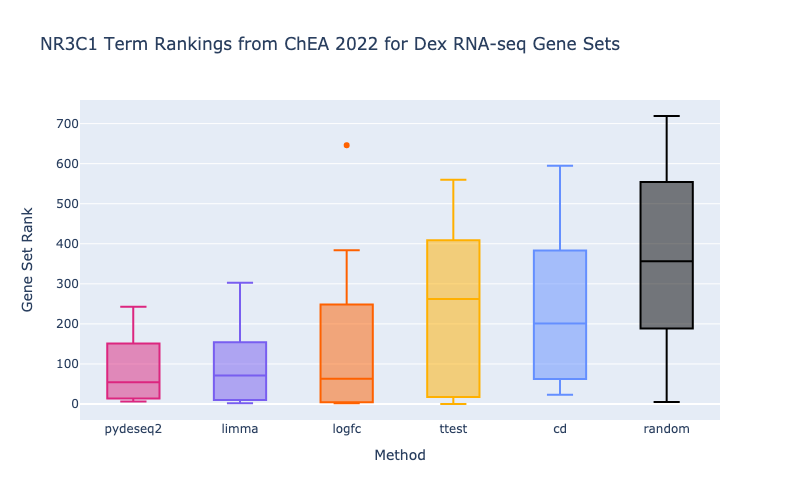

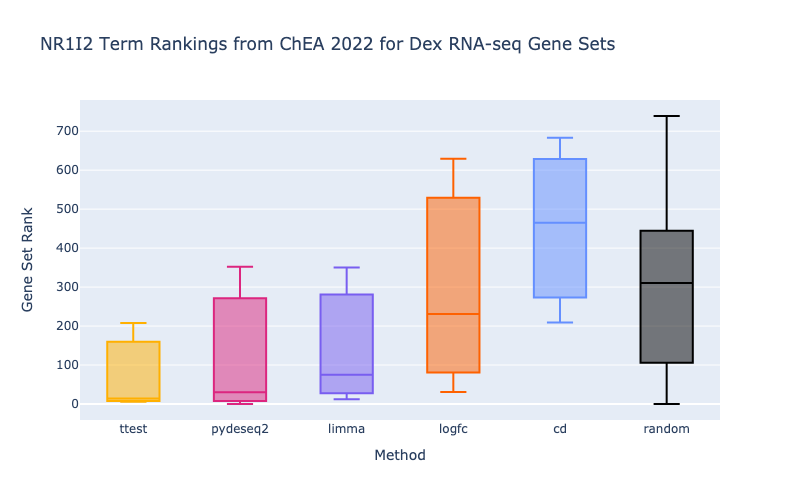

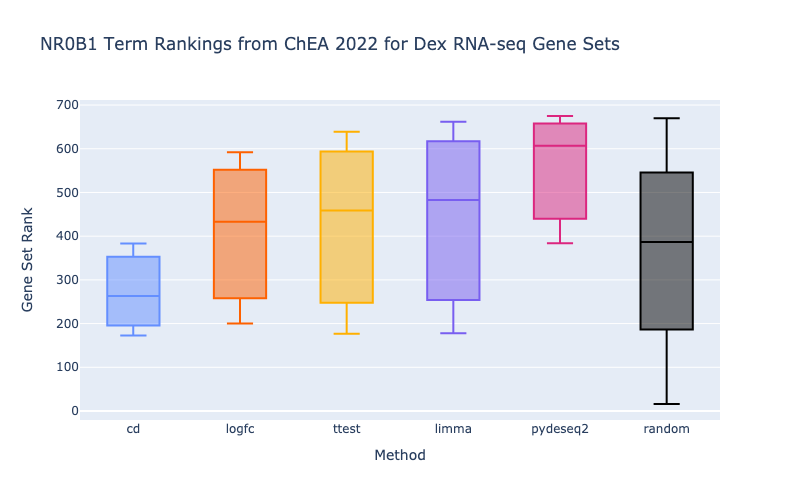

In [161]:
method_color_map = {
    'random': 'black',
    'cd': '#648FFF',
    'limma': '#785EF0',
    'pydeseq2': '#DC267F',
    'logfc': '#FE6100',
    'ttest': '#FFB000',
    'ranksum': '#B3B3B3',
    'paired-ttest': '#009E73'
}
for tf in dex_chea2022_df['TF'].unique():
    sub_df = dex_chea2022_df[dex_chea2022_df['TF']==tf].set_index(['Method'])
    sub_df = sub_df[sub_df['Term'].apply(lambda x: 'MLEC' not in x and 'WistarRat' not in x)]
    fig1 = go.Figure()
    for gs in sub_df.groupby(['Method']).mean(numeric_only=True).sort_values('Rank').index:
        fig1.add_trace(
            go.Box(
                y=sub_df.loc[gs]['Rank'].tolist(),
                name=gs, 
                marker_color=method_color_map[gs.split(':')[0]]
            )
        )
    sub_rand_df = rand_chea2022_df[rand_chea2022_df['TF'] == tf]
    fig1.add_trace(
        go.Box(
            y=sub_rand_df['Rank'].tolist(),
            name='random',
            marker_color='black'
        )
    )

    fig1.update_layout(
        width=800,
        title_text=f"{tf} Term Rankings from ChEA 2022 for Dex RNA-seq Gene Sets",
        xaxis={
            'title': {'text': 'Method'}, 
        },
        yaxis={
            'title': {'text': 'Gene Set Rank'}
        },
        showlegend=False
    )
    fig1.show("png")

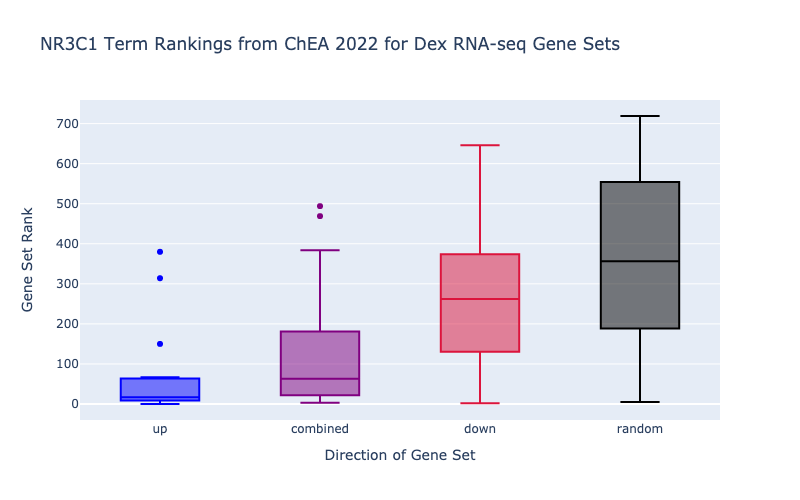

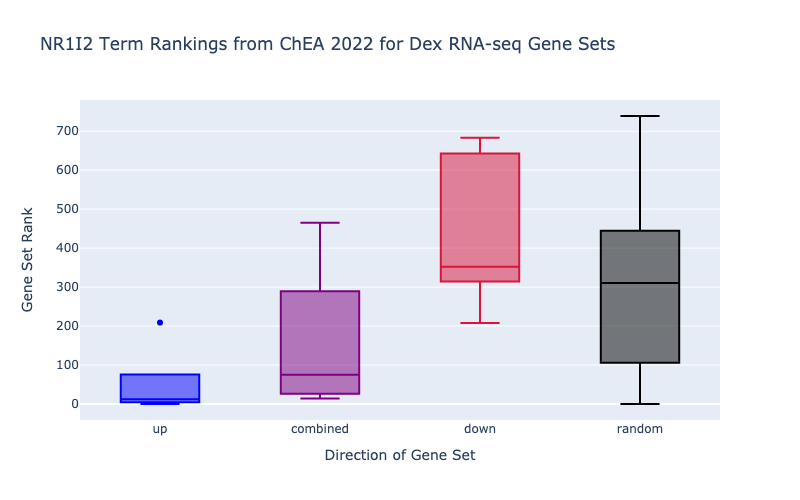

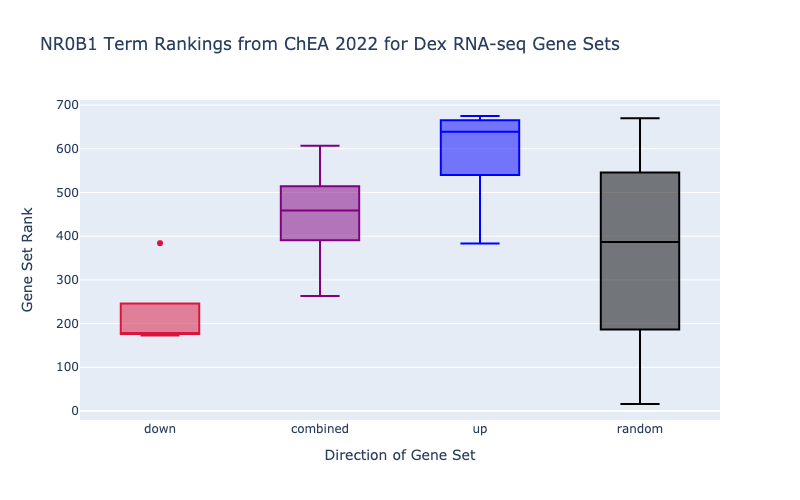

In [162]:
method_color_map = {
    'up': 'blue',
    'down': 'crimson',
    'combined': 'purple'
}
for tf in dex_chea2022_df['TF'].unique():
    sub_df = dex_chea2022_df[dex_chea2022_df['TF']==tf].set_index(['Direction'])
    sub_df = sub_df[sub_df['Term'].apply(lambda x: 'MLEC' not in x and 'WistarRat' not in x)]
    fig1 = go.Figure()
    for gs in sub_df.groupby(['Direction']).mean(numeric_only=True).sort_values('Rank').index:
        fig1.add_trace(
            go.Box(
                y=sub_df.loc[gs]['Rank'].tolist(),
                name=gs, 
                marker_color=method_color_map[gs]
            )
        )
    sub_rand_df = rand_chea2022_df[rand_chea2022_df['TF'] == tf]
    fig1.add_trace(
        go.Box(
            y=sub_rand_df['Rank'].tolist(),
            name='random',
            marker_color='black'
        )
    )

    fig1.update_layout(
        width=800,
        title_text=f"{tf} Term Rankings from ChEA 2022 for Dex RNA-seq Gene Sets",
        xaxis={
            'title': {'text': 'Direction of Gene Set'}, 
        },
        yaxis={
            'title': {'text': 'Gene Set Rank'}
        },
        showlegend=False
    )
    fig1.show("png")

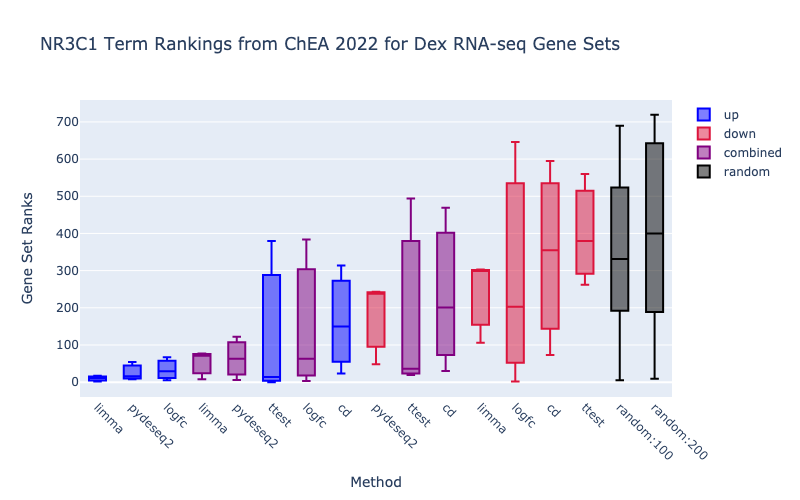

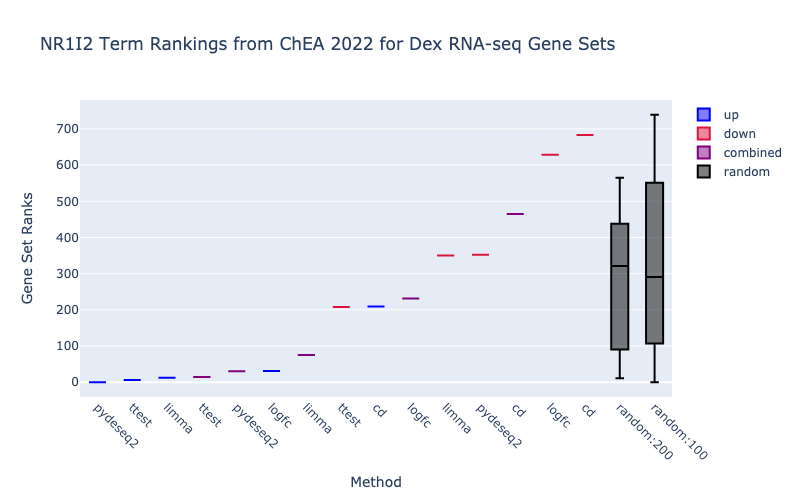

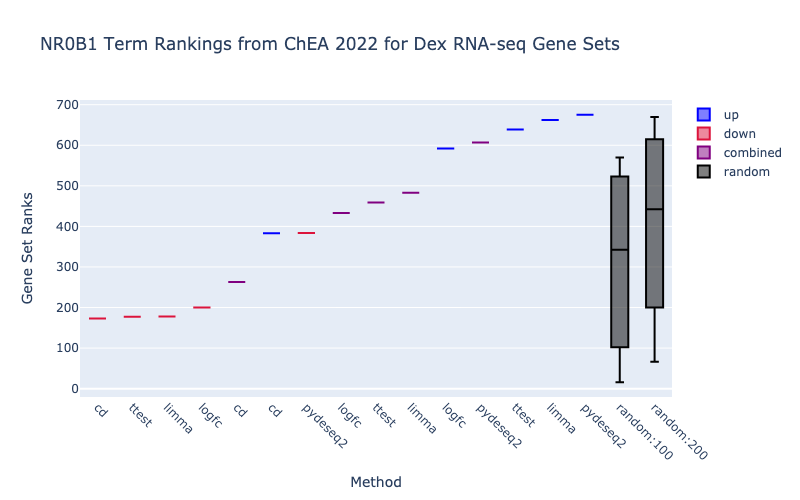

In [136]:
method_color_map = {
    'up': 'blue',
    'down': 'crimson',
    'combined': 'purple'
}

for tf in dex_chea2022_df['TF'].unique():
    sub_df = dex_chea2022_df[dex_chea2022_df['TF']==tf]
    sub_df = sub_df[sub_df['Term'].apply(lambda x: 'MLEC' not in x and 'WistarRat' not in x)]
    x_order = sub_df.groupby(['Gene_Set']).mean(numeric_only=True).sort_values('Rank').reset_index().rename_axis('Order').reset_index().set_index('Gene_Set')
    x_order['Labels'] = x_order.index.map(lambda x: x.split(':')[0]).tolist()
    fig1 = go.Figure()
    for d in sub_df['Direction'].unique(): 
        d_df = sub_df[sub_df['Direction'] == d]
        fig1.add_trace(
            go.Box(
                x=[x_order.loc[x, 'Order'] for x in d_df['Gene_Set']],
                y=d_df['Rank'],
                name=d, 
                marker_color=method_color_map[d]
            )
        )
    sub_rand_df = rand_chea2022_df[rand_chea2022_df['TF'] == tf]
    rand_x_order = sub_rand_df.groupby(['Gene_Set']).mean(numeric_only=True).sort_values('Rank').reset_index()
    rand_x_order['Order'] = [x + x_order.shape[0] for x in rand_x_order.index.tolist()]
    rand_x_order['Labels'] = rand_x_order['Gene_Set'].tolist()
    rand_x_order = rand_x_order.set_index('Gene_Set')
    fig1.add_trace(
        go.Box(
            x=[rand_x_order.loc[x, 'Order'] for x in sub_rand_df['Gene_Set']],
            y=sub_rand_df['Rank'],
            name='random',
            marker_color='black'
        )
    )
    fig1.update_layout(
        width=800,
        title_text=f"{tf} Term Rankings from ChEA 2022 for Dex RNA-seq Gene Sets",
        xaxis={
            'title': {'text': 'Method'}, 
        },
        yaxis={
            'title': {'text': 'Gene Set Ranks'}
        }
    )
    fig1.update_xaxes(
        tickmode='array',
        tickangle=45,
        tickvals = x_order['Order'].tolist() + rand_x_order['Order'].tolist(),
        ticktext=x_order['Labels'].tolist() + rand_x_order['Labels'].tolist()
    )
    fig1.show("png")

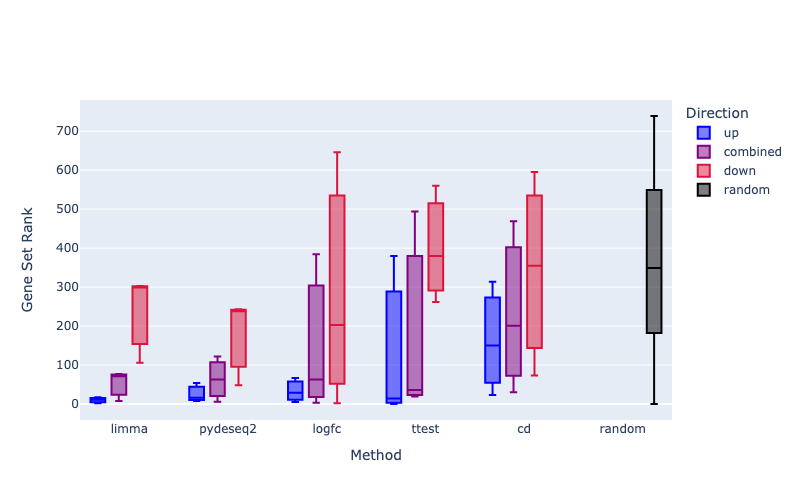

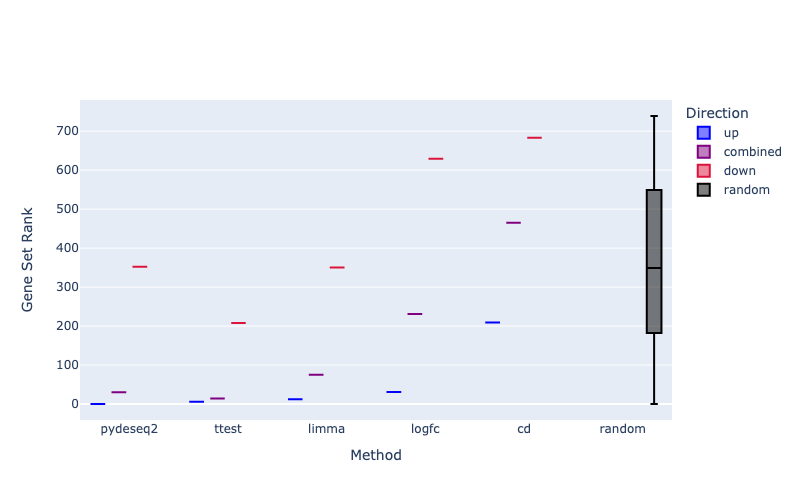

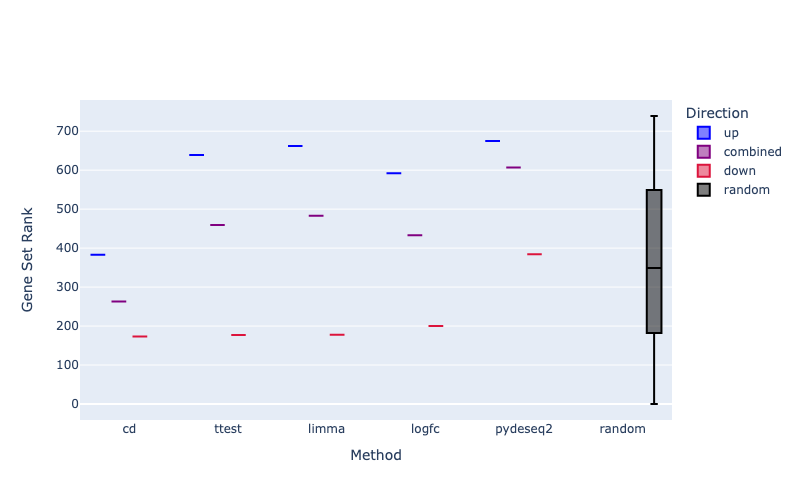

In [170]:
method_color_map = {
    'up': 'blue',
    'down': 'crimson',
    'combined': 'purple'
}
for tf in dex_chea2022_df['TF'].unique():
    fig1 = go.Figure()
    sub_df = dex_chea2022_df[dex_chea2022_df['TF']==tf]
    sub_df = sub_df[sub_df['Term'].apply(lambda x: 'MLEC' not in x and 'WistarRat' not in x)]
    order = sub_df.groupby('Gene_Set').mean(numeric_only=True).sort_values('Rank').index.map(lambda x: x.split(':')[0]).unique()
    sub_df['Method'] = pd.Categorical(sub_df['Method'], order)
    sub_df = sub_df.sort_values(by=['Method'])
    for d in ['up', 'combined', 'down']:
        fig1.add_trace(go.Box(
            x=sub_df[sub_df['Direction'] == d]['Method'],
            y=sub_df[sub_df['Direction'] == d]['Rank'],
            name=d, 
            marker_color=method_color_map[d]
        ))
    fig1.add_trace(go.Box(
        x=rand_df['Method'],
        y=rand_df['Rank'],
        name='random', 
        marker_color='black'
    ))
    fig1.update_layout(
        width=800,
        boxmode='group',
        boxgap=0.15,
        xaxis={
            'title': {'text': 'Method'}, 
        },
        yaxis={
            'title': {'text': 'Gene Set Rank'}
        },
        legend_title_text="Direction"
    )
    fig1.show("png")
    if tf == 'NR3C1': 
        fig1.write_image('/Users/maayanlab/Documents/manuscripts/dex-benchmark/revised_figures/2C_300dpi.png', scale=(800/300))

In [168]:
method_color_map = {
    'random': 'black',
    'cd': '#648FFF',
    'limma': '#785EF0',
    'pydeseq2': '#DC267F',
    'logfc': '#FE6100',
    'ttest': '#FFB000',
    'ranksum': '#B3B3B3',
    'paired-ttest': '#009E73'
}
for tf in dex_chea2022_df['TF'].unique():
    sub_df = dex_chea2022_df[dex_chea2022_df['TF']==tf]
    sub_df = sub_df[sub_df['Term'].apply(lambda x: 'MLEC' not in x and 'WistarRat' not in x)]
    order = sub_df.groupby('Gene_Set').mean(numeric_only=True).sort_values('Rank').index.map(lambda x: x.split(':')[0]).unique()
    sub_df['Method'] = pd.Categorical(sub_df['Method'], order)
    sub_df['Direction'] = pd.Categorical(sub_df['Direction'], ['up', 'combined', 'down'])
    sub_df = sub_df.sort_values(by=['Direction', 'Method'])

    fig1 = go.Figure()
    for method in sub_df['Method'].unique(): 
      m_df = sub_df[sub_df['Method'] == method]
      fig1.add_trace(go.Box(
          x=m_df[m_df['Method'] == method]['Direction'],
          y=m_df[m_df['Method'] == method]['Rank'],
          name=method, 
          marker_color=method_color_map[method]
      ))
    sub_rand_df = rand_df[rand_df['TF'] == tf]
    fig1.add_trace(go.Box(
      x=sub_rand_df['Method'],
      y=sub_rand_df['Rank'],
      name='random', 
      marker_color='black'
    ))
    fig1.update_layout(
      width=800,
      boxmode='group',
      boxgap=0.1,
      xaxis={
          'title': {'text': 'Direction'}, 
      },
      yaxis={
          'title': {'text': 'Gene Set Rank'}
      },
      legend_title_text="Method"
    )
    fig1.show()    
    if tf == 'NR3C1': 
        fig1.write_image('/Users/maayanlab/Documents/manuscripts/dex-benchmark/revised_figures/2D_300dpi.png', scale=(800/300))

## Bridge plots

The below plots provide the Brownian bridge plots comparing the ranked genes from each method signature with the genes in the target TF gene sets.

In [308]:
target_genesets = []
target_genesets.append({t:chea2022[t] for t in dex_chea2022_df['Term'].unique() if ('MLEC' not in t and 'Wistar' not in t)})

In [280]:
def singleBridgePlot(gsname, signame, target_gs):
    geneset = target_gs[gsname]
    if signame == 'cd' or signame == 'logfc':
        sorted_genes = signatures[signame].sort_values(by='Significance', ascending=False)
    else: 
        sorted_genes = signatures[signame].sort_values(by=['Significance'], ascending=True)
    select = pd.Series(
        [x.upper() in geneset for x in sorted_genes.index.tolist()]
    )
    x, y = bridge_plot(select)
    x = x/len(x)
    return x,y

def randomBridgePlot(gsname, target_gs): 
    all_x = []
    all_y = []

    for _ in range(10):
        rand_sig = sample(
            signatures['logfc'].index.tolist(), 
            signatures['logfc'].shape[0]
        )
        select = pd.Series([
            x.upper() in target_gs[gsname] for x in rand_sig
        ])
        x, y = bridge_plot(select)
        x = x/len(x)
        all_x.append(x)
        all_y.append(y)

    return all_x, all_y

In [262]:
def build_tf_res(target_gs):
    tf_res = {tf: {'random': {'x': [], 'y': []}} for tf in full_df['TF'].unique()}
    for gs in target_gs.keys():
        tf = gs.split(' ')[0].split('_')[0]
        rand_x, rand_y = randomBridgePlot(gs, target_gs)
        tf_res[tf]['random']['x'] += rand_x
        tf_res[tf]['random']['y'] += rand_y
        for sig in signatures.keys():
            temp_x, temp_y = singleBridgePlot(gs, sig, target_gs)
            if sig in tf_res[tf].keys():
                tf_res[tf][sig]['x'].append(temp_x)
                tf_res[tf][sig]['y'].append(temp_y)
            else: 
                tf_res[tf][sig] = {'x': [temp_x], 'y': [temp_y]}
    return tf_res

In [281]:
significance_tf_results = [] 
for i in range(len(target_genesets)): 
    significance_tf_results.append(build_tf_res(target_genesets[i]))

In [309]:
libraries = ['ChEA 2022']

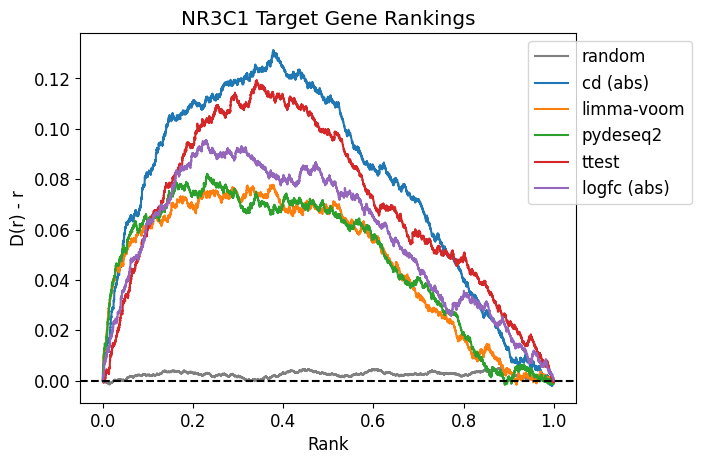

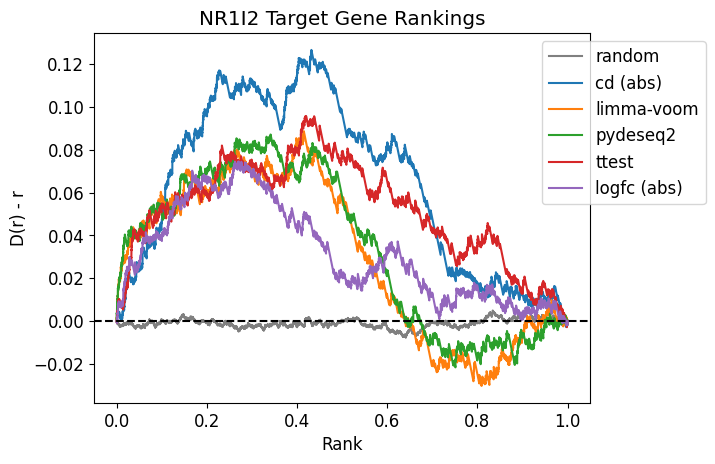

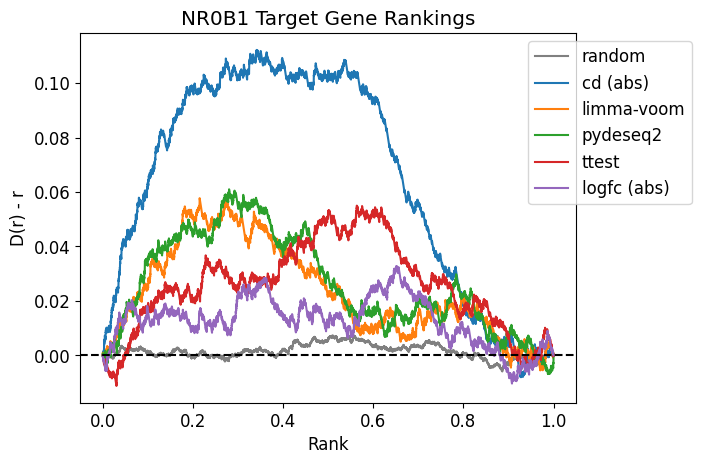

In [330]:
# with opposite direction queries
matplotlib.rcParams.update({'font.size': 12})
for tf in full_df['TF'].unique():
    fig = plt.figure()
    tf_x = {method: [] for method in significance_tf_results[0][tf].keys()}
    tf_y = {method: [] for method in significance_tf_results[0][tf].keys()}
    for i in range(len(target_genesets)):
      for sig in significance_tf_results[i][tf].keys(): 
        tf_x[sig].append(np.mean(significance_tf_results[i][tf][sig]['x'], axis=0))
        tf_y[sig].append(np.mean(significance_tf_results[i][tf][sig]['y'], axis=0))
    for m in tf_x.keys():
      if m == 'random': 
          plt.plot(np.mean(tf_x[m], axis=0), np.mean(tf_y[m], axis=0), label=m, color='gray')
      elif m == 'cd' or m == 'logfc': 
          plt.plot(np.mean(tf_x[m], axis=0), np.mean(tf_y[m], axis=0), label=m + ' (abs)')
      else:
          label = m.replace('limma', 'limma-voom')
          plt.plot(np.mean(tf_x[m], axis=0), np.mean(tf_y[m], axis=0), label=label)

    plt.axhline(y=0, color='black', linestyle='dashed')
    plt.legend(bbox_to_anchor=(1.25, 1))
    plt.title(f"{tf} Target Gene Rankings")
    plt.xlabel('Rank')
    plt.ylabel('D(r) - r')
    plt.show()
    
    if tf == 'NR3C1':
        fig.savefig('../../publicationfigs/Figure2E.png', format='png', dpi=300, bbox_inches='tight')

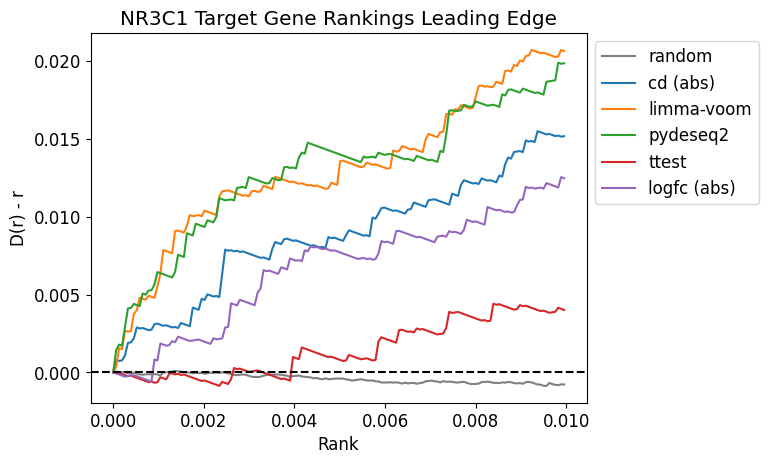

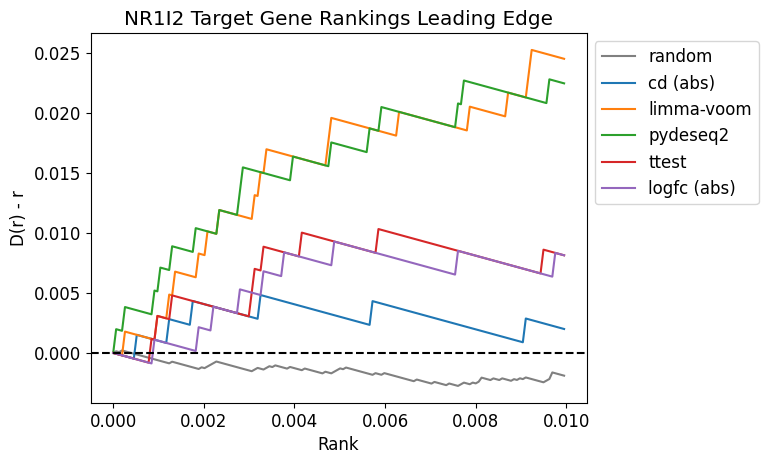

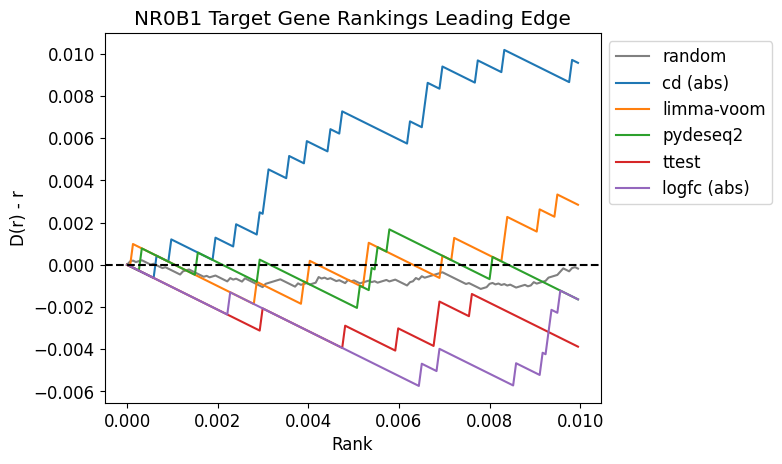

In [329]:
# with manual libraries
matplotlib.rcParams.update({'font.size': 12})
for tf in full_df['TF'].unique():
    fig = plt.figure()
    tf_x = {method: [] for method in significance_tf_results[0][tf].keys()}
    tf_y = {method: [] for method in significance_tf_results[0][tf].keys()}
    for i in range(len(libraries)):
      for sig in significance_tf_results[i][tf].keys(): 
        tf_x[sig].append(np.mean(significance_tf_results[i][tf][sig]['x'], axis=0))
        tf_y[sig].append(np.mean(significance_tf_results[i][tf][sig]['y'], axis=0))
    for m in tf_x.keys():
      try:
        leading_x = [arr[:ceil(0.01*len(arr))] for arr in tf_x[m]]
        leading_y = [arr[:ceil(0.01*len(arr))] for arr in tf_y[m]]
      except:
        leading_x = tf_x[m][0][:ceil(0.01*len(tf_x[m][0]))]
        leading_y = tf_y[m][0][:ceil(0.01*len(tf_y[m][0]))]
      if m == 'random': 
        plt.plot(np.mean(leading_x, axis=0), np.mean(leading_y, axis=0), label=m, color='gray')
      elif m == 'cd' or m == 'logfc': 
          plt.plot(np.mean(leading_x, axis=0), np.mean(leading_y, axis=0), label=m + ' (abs)')
      else:
        label = m.replace('limma', 'limma-voom')
        plt.plot(np.mean(leading_x, axis=0), np.mean(leading_y, axis=0), label=label)

    plt.axhline(y=0, color='black', linestyle='dashed')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title(f"{tf} Target Gene Rankings Leading Edge")
    plt.xlabel('Rank')
    plt.ylabel('D(r) - r')
    plt.show()

    if tf == 'NR3C1': 
      fig.savefig('../../publicationfigs/Figure2F.png', format='png', dpi=300, bbox_inches='tight')

## Signature similarity

In [296]:
rank_comparison = pd.concat([
  signatures['cd']['CD-coefficient'].rename('CD').rank(),
  signatures['limma']['t'].rename('Limma').rank(),
  signatures['pydeseq2']['stat'].rename('DESeq2').rank(),
  signatures['logfc']['logFC'].apply(abs).rename('FC').rank(),
  signatures['ttest']['Statistic'].rename('Ttest').rank()
], axis=1)

In [297]:
expr_comparison = pd.concat([
  signatures['cd']['CD-coefficient'].rename('CD'),
  signatures['limma']['t'].rename('Limma'),
  signatures['pydeseq2']['stat'].rename('DESeq2'),
  signatures['logfc']['logFC'].apply(abs).rename('FC'),
  signatures['ttest']['Statistic'].rename('Ttest')
], axis=1)

In [298]:
sns.set(font_scale=1.4)

### Correlation of signature expression values

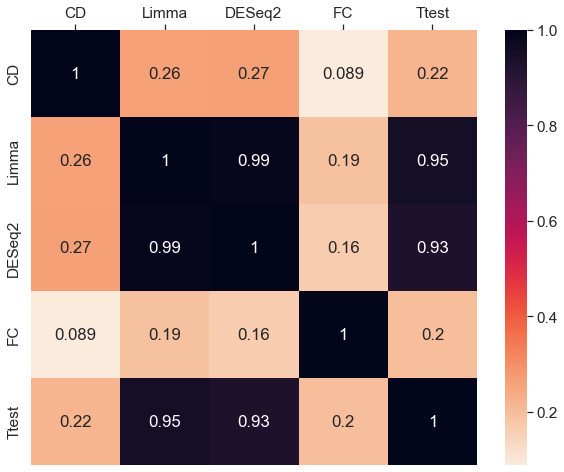

In [299]:
expr_correlations = 1-pairwise_distances(
  expr_comparison.T, metric='cosine'
)
np.fill_diagonal(expr_correlations, 1)

hm, hm_ax = plt.subplots(figsize=(10,8))  
sns.heatmap(pd.DataFrame(
  expr_correlations, index=expr_comparison.columns, columns=expr_comparison.columns
), cmap=sns.cm.rocket_r, annot=True)
hm_ax.xaxis.tick_top()

### Correlation of signature gene ranks

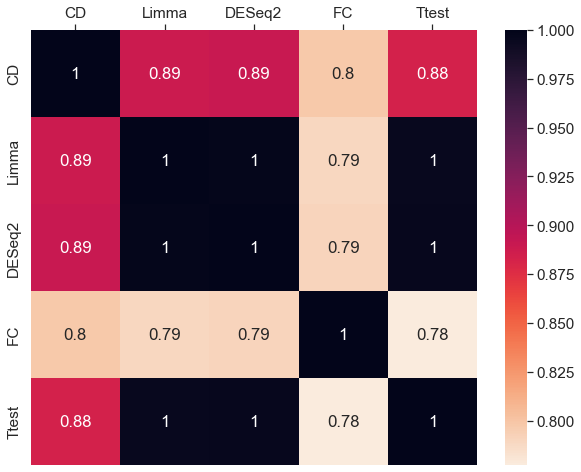

In [300]:
rank_correlations = 1-pairwise_distances(
  rank_comparison.T, metric='cosine'
)
np.fill_diagonal(rank_correlations, 1)

hm, hm_ax = plt.subplots(figsize=(10,8))  
sns.heatmap(pd.DataFrame(
  rank_correlations, index=rank_comparison.columns, columns=rank_comparison.columns
), cmap=sns.cm.rocket_r, annot=True)
hm_ax.xaxis.tick_top()